In [283]:
from tqdm import tqdm
import pandas as pd
import numpy as np

from sklearn.feature_selection import SelectKBest, f_classif, f_oneway, mutual_info_classif, VarianceThreshold, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import KernelPCA, PCA
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split, cross_val_score, cross_validate
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from lightgbm.sklearn import LGBMClassifier

import warnings 
warnings.filterwarnings("ignore")
NUM_TRIALS = 1000
SEED = 42420
scv = StratifiedKFold(n_splits=5)

In [301]:
df = pd.read_csv('Crop_Location_Data_20221201.csv')
s1_data = np.load('sar_data.npy') #Sentinel-2 data
s2_data = np.load('sentinel2_data_train.npy')[:,:4,:]

In [383]:
from sklearn.feature_selection import RFECV
from sklearn.manifold import TSNE
from sklearn.preprocessing import SplineTransformer

def prep_s2_data(data):
    data[data == 0] = np.nan
    red = data[:,0,:]
    nir = data[:,3,:]
    ndvi_mean_clean = (nir-red)/(nir+red)
    ndvi = pd.DataFrame(ndvi_mean_clean)
    return ndvi

def prep_s1_data(data):
    vv = data[:,0,:]
    vh = data[:,1,:]
    q = vh/vv
    n = q*(q+3)
    d = (q+1)**2
    rvi = n/d #CALCULATION OF Radar Vegetation Index
    if len(data.shape) == 3:
        rvi = rvi.reshape(data.shape[0],1,data.shape[2])
    else:
        rvi = rvi.reshape(data.shape[0],1)
    rvi = np.nan_to_num(rvi, nan=0)
    new_data = np.concatenate((data,rvi),axis=1).copy()
    return new_data

proc_pipe = Pipeline([
      ('thresh', VarianceThreshold()), #Remove colmns with constant features
      ('spline', SplineTransformer(n_knots=6, degree=5, extrapolation='periodic')),
      ('scale', StandardScaler()), #Scale the data
    #   ('fe', PolynomialFeatures(degree=3)),
      ('select_feats1', SelectKBest(f_classif, k=100)), #select top 50 features using f_classif strategy
    #   ('select_feats', SelectFromModel(XGBClassifier(random_state=40), max_features=50)),
      ('select_feats2', RFECV(XGBClassifier(random_state=40), step=0.1, min_features_to_select=30)),
      ('tsne', KernelPCA(n_components=5, kernel='poly', random_state=42))
])

def create_col_names(features=['VV','VH','RVI'],timesteps=52):
    cols = [f'{feat}_{t}' for feat in features for t in range(0,timesteps)]
    dicts = {t:c for t,c in zip(range(0,len(features)*timesteps),cols)}
    return dicts

def proc_pipeline(s1data,s2data):
    data_s1 = s1data[:,:,:52].copy()
    data_s1 = prep_s1_data(data_s1)
    data_s1 = pd.DataFrame(data_s1.reshape(data_s1.shape[0],data_s1.shape[1]*data_s1.shape[2]))
    if s2data is not None:
        data_s2 = prep_s2_data(s2data)
        complete_df = pd.concat([data_s1,data_s2],axis=1, ignore_index=True)
        return complete_df
    else:
        return data_s1

In [384]:
complete_df = proc_pipeline(s1_data, None)
dicts = create_col_names()
complete_df.rename(columns=dicts,inplace=True)

In [385]:
complete_df

,VV_0,VV_1,VV_2,VV_3,VV_4,VV_5,VV_6,VV_7,VV_8,VV_9,...,RVI_42,RVI_43,RVI_44,RVI_45,RVI_46,RVI_47,RVI_48,RVI_49,RVI_50,RVI_51
0,0.039149,0.034205,0.044161,0.029956,0.032765,0.026254,0.075706,0.084049,0.041761,0.026061,...,1.109153,1.120790,1.110529,1.104947,1.110555,1.115490,1.088580,1.094324,1.053526,1.064133
1,0.026118,0.036568,0.041516,0.030507,0.064327,0.026621,0.094764,0.021684,0.017601,0.005918,...,1.123149,1.124229,1.123904,1.109489,1.124946,1.096108,1.101996,1.124556,1.043715,1.021130
2,0.044205,0.031559,0.039120,0.018742,0.043604,0.026554,0.058810,0.076552,0.038845,0.017549,...,1.114845,1.119457,1.117225,1.112082,1.118335,1.118586,1.122740,1.118968,1.034430,1.035563
3,0.041290,0.032280,0.042852,0.038250,0.044909,0.034352,0.053895,0.052763,0.046522,0.022569,...,1.124986,1.124999,1.111018,1.097056,1.107514,1.059901,1.099912,1.113194,1.080739,1.032652
4,0.022037,0.028693,0.036434,0.033285,0.085088,0.041033,0.049838,0.008084,0.008059,0.006776,...,1.124550,1.117012,1.117879,1.116569,1.124795,1.114218,1.110528,1.118907,1.034686,1.038039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.094441,0.099455,0.068456,0.089796,0.081265,0.057693,0.104882,0.119630,0.050866,0.095835,...,1.121684,1.110466,1.122813,1.123018,1.124222,1.112234,1.124525,1.119723,1.121672,1.114054
596,0.093986,0.114299,0.073228,0.104556,0.071013,0.053510,0.089211,0.069450,0.078184,0.109110,...,1.116106,1.110371,1.122510,1.120203,1.119964,1.124865,1.120409,1.124742,1.117305,1.120384
597,0.082631,0.099725,0.063362,0.078933,0.078904,0.067436,0.062394,0.063671,0.049033,0.099516,...,1.107018,1.120214,1.102492,1.121064,1.099339,1.124331,1.110506,1.124108,1.112376,1.107478
598,0.075545,0.095171,0.063125,0.097325,0.097000,0.068528,0.059935,0.081552,0.066601,0.072443,...,1.121916,1.115790,1.119424,1.119727,1.122595,1.124803,1.114920,1.119903,1.124957,1.117045


In [386]:
le = LabelEncoder()
y = le.fit_transform(df['Class of Land'])
X = proc_pipe.fit_transform(complete_df,y)
sel_feats = proc_pipe.get_feature_names_out().tolist()
X.shape

(600, 5)

In [387]:
df_ = pd.DataFrame(X,columns=sel_feats)
df_['Target'] = y

In [388]:
import plotly.graph_objects as go

# Create a list to store data traces
traces = []

# Create a violin plot for each feature variable
for feature_name, feature_values in df_.items():
    trace = go.Violin(y=feature_values, x=y, name=feature_name, box_visible=True, meanline_visible=True)
    traces.append(trace)

# Create the figure
fig = go.Figure(data=traces)

# Update layout
fig.update_layout(title='Violin Plot of Feature Variables by Target Class', yaxis_title='Feature Value', xaxis_title='Target Class')

# Show plot
fig.show()


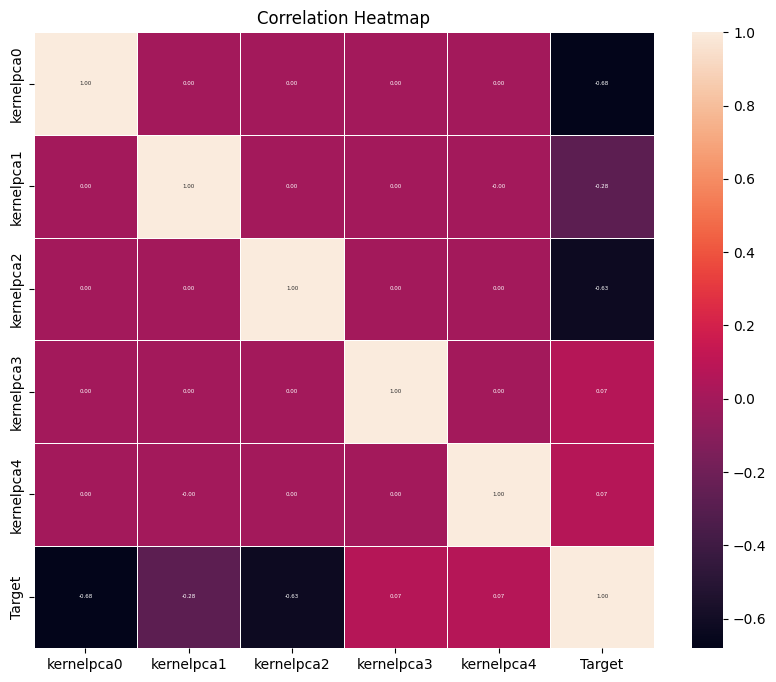

In [389]:
import seaborn as sns
import matplotlib.pyplot as plt

def correlation_plot(dataframe):
    """
    Generates a correlation heatmap plot using Seaborn.

    Parameters:
    - dataframe: pandas DataFrame containing numeric columns.

    Returns:
    - None (displays the plot).
    """
    # Calculate correlation matrix
    corr_matrix = dataframe.corr()

    # Generate a heatmap using Seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidths=0.5, annot_kws={"size": 4})
    plt.title('Correlation Heatmap')
    plt.show()

correlation_plot(df_)

In [390]:
from sklearn.manifold import TSNE
import plotly.express as px

def tsne_plot(dataframe, target_column):
    """
    Generates a t-SNE plot using Plotly with hover information to visualize high-dimensional data.

    Parameters:
    - dataframe: pandas DataFrame containing numeric columns.
    - target_column: Name of the target column in the DataFrame.

    Returns:
    - fig: Plotly Figure object containing the t-SNE plot with hover information.
    """
    # Extract features and target variable
    X = dataframe.drop(columns=[target_column])
    y = dataframe[target_column]

    # Initialize t-SNE object
    tsne = TSNE(n_components=2, random_state=42)

    # Fit and transform the data
    X_tsne = tsne.fit_transform(X)

    # Create hover text with sample indices
    hover_text = ['Index: {}'.format(index) for index in dataframe.index]

    # Create Plotly scatter plot with hover information
    fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=y, labels={'x': 't-SNE Component 1', 'y': 't-SNE Component 2'}, color_continuous_scale='viridis', title='t-SNE Plot', hover_name=hover_text)
    fig.update_coloraxes(colorbar_title=target_column)

    return fig, X_tsne

# Example usage:
# Replace 'df' with your DataFrame and 'target_column' with the name of your target column
fig, tsne = tsne_plot(df_, 'Target')

fig.show()


In [294]:
df = df_.copy()
train = df.iloc[[370,146],:]
test = df.iloc[[292,234,112],:]
df_ = df.drop([370,234,146,112,292])
X = df_.drop(['Target'],axis=1)
y = df_['Target']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3,shuffle=True, random_state=807410395)
X_train = pd.concat([X_train,train.drop(['Target'],axis=1)]).reset_index(drop=True)
y_train = pd.concat([y_train,train['Target']]).reset_index(drop=True)
X_test = pd.concat([X_test,test.drop(['Target'],axis=1)]).reset_index(drop=True)
y_test = pd.concat([y_test,test['Target']]).reset_index(drop=True)
X = df.drop(['Target'],axis=1)
y = df['Target']
X_train.shape, y_train.sum()

((418, 10), 209)

In [295]:
clf = LGBMClassifier(random_state=5000)
def rank_seeds(clf, topk=10):
    sd = {}
    for seed in tqdm(range(0,NUM_TRIALS)):
        scv = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
        score = cross_val_score(clf, X_train, y_train, cv=scv.split(X_train, y_train), scoring='accuracy').mean()
        sd.update({seed:score})
    seeds = pd.DataFrame(list(sd.items()), columns=['Seed', 'Score']).sort_values('Score',ascending=True).index[0:topk].values.tolist()
    return seeds
# rank_seeds(clf)

In [296]:
#[621, 782, 209, 1922, 1897, 1620, 1992, 1627, 1599, 217]
scv = StratifiedKFold(n_splits=5, random_state=621, shuffle=True)
score = cross_val_score(clf, X_train, y_train, cv=scv.split(X_train, y_train), scoring='accuracy').mean()
score

0.9856569133677567

In [240]:
model = clf.fit(X,y)
coefs = model.feature_importances_.tolist()#[0]
feat_imp = {c:i for c,i in zip(sel_feats,[abs(c) for c in coefs])}

In [241]:
sorted_features = sorted(feat_imp.items(), key=lambda x: x[1], reverse=True)
features = [item[0] for item in sorted_features]
importance_scores = [item[1] for item in sorted_features]

fig = go.Figure(data=[go.Bar(x=features, y=importance_scores)])
fig.update_layout(title='Feature Importance', xaxis_title='Feature', yaxis_title='Importance Score')
fig.show()

In [242]:
#NESTED CV STRATEGY TO SCORE THE VALIDATION SET
def nested_cv(
    pipe,
    X,
    y,
    grid,
    splits,
    iters=5,
    seed=42,
    metrics="accuracy",
):
    inner_cv = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)
    outer_cv = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)
    clf = RandomizedSearchCV(estimator=pipe, n_iter=iters, param_distributions=grid, cv=inner_cv, 
                            scoring=metrics, n_jobs=-1, random_state=SEED)
    scores = cross_validate(clf, X=X, y=y, cv=outer_cv, scoring=metrics, return_estimator=True)
    model_params = [e.best_estimator_ for e in scores["estimator"]]
    return {
        "model_params": model_params,
        "accuracy": scores["test_score"],
    }

#FUNCTION TO RUN MULTIPLE NESTED CV TRIALS
def run_cvs(pipe, X, y, grid, splits=10, iters=5, metrics = 'accuracy'):
    cv_results = pd.DataFrame()
    row_res = {}

    for i in tqdm(range(NUM_TRIALS)): #ITERATE THROUGH NUMBER OF TRIALS
        row_res["seed"] = i
        cv_res = nested_cv(pipe, X, y, grid=grid, splits=splits, iters=iters, seed=i, metrics=metrics)
        row_res.update(cv_res)
        temp_res = pd.DataFrame(row_res, columns=list(row_res.keys()))
        cv_results = pd.concat([cv_results, temp_res], axis=0, ignore_index=True)
        row_res = {}
    return cv_results

#FUNCTION TO FIND THE WORST PERFORMING TRIAL OUT OF ALL THE TRIALS
def find_worst_seeds(res, topk=5):
    seeds = []
    for seed in res.groupby('seed')['accuracy'].mean().sort_values(ascending=True).index[0:topk].values:
        seeds.append(seed)
    return seeds

In [243]:
#BLOCK TO FIND THE WORST PERFORMING SEED ON THE DATA
lr_params = {
    "fit_intercept": [True, False],
    "C": np.linspace(0.01, 0.5, 40, dtype=np.float32),
    # "l1": np.linspace(0.1, 1.0, 40, dtype=np.float32),
    "solver": ["lbfgs"],
    "penalty": ["l2"],
}
clf = LogisticRegression(max_iter=200,random_state=420)
res_ridge = run_cvs(clf, X_train, y_train, lr_params, splits=5, iters=1, metrics='f1_weighted')
seeds = find_worst_seeds(res_ridge, topk=10)

100%|██████████| 1000/1000 [01:24<00:00, 11.79it/s]


In [244]:
seeds

[0, 658, 659, 660, 661, 662, 663, 664, 665, 666]

In [245]:
seeds = [0]#[1633, 125, 1842, 1429, 340, 1344, 1088, 1956, 1114, 1682]

In [246]:
#MAKING VOTING CLASSIFIER USING A LIST OF MODELS
def make_vc(search_list, name_list):
    estimator_list = [(str(n), s) for n,s in zip(name_list, search_list)]
    return VotingClassifier(estimators=estimator_list, voting='soft')

def evaluate(clf):
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    print(classification_report(y_test,predictions))

def predict_submission(clf, use_s2=False):
    testdfs1 = np.load('sar_data_test.npy')
    if use_s2:
        testdfs2 = np.load('sentinel2_data_test.npy')
        proc_testdf = proc_pipeline(testdfs1,testdfs2)
    else:
        proc_testdf = proc_pipeline(testdfs1,None)
    X_sub = proc_pipe.transform(proc_testdf)
    clf.fit(X,y)
    submission_predictions = clf.predict(X_sub)
    submission_probs = clf.predict_proba(X_sub)
    return submission_predictions, submission_probs

#THE FUNCTION TO CREATE VOTING CLASSIFIER BASED ON PERFORMANCE ON WORST PERFORMING SEED
def score_worst_seeds(clf, params, X, y, seeds, iters=100):
    model_ls = []
    valid_scores = []

    for seed in tqdm(seeds):
        cv_res = nested_cv(clf, X, y, grid=params, splits=5, iters=iters, seed=seed, metrics='f1_weighted')
        cv_models = cv_res['model_params']
        model = make_vc(cv_models, list([i for i in range(0,5)]))
        score = cv_res['accuracy'].mean()
        model_ls.append(model)
        valid_scores.append(score*100)

    print(f'The mean accuracy for the {len(seeds)} worst seeds is {np.mean(valid_scores)} and the std. dev. is {np.std(valid_scores)}')
    return make_vc(model_ls, seeds)

In [255]:
from sklearn.neural_network import MLPClassifier


mlp_params = {
    # 'hidden_layer_sizes': [(128,64), (128,64,32), (128,64,32,16), (128,64,32,16,8), (128,64,32,16,4)],
    'activation': ['relu', 'tanh', 'logistic'],
    # 'solver': ['adam'],
    'alpha': np.linspace(0.00001, 1.0, 20, dtype=np.float16),
    'learning_rate': ['constant', 'adaptive', 'invscaling'],
    'learning_rate_init': np.linspace(1e-6, 1e-4, 10, dtype=np.float16),
    # 'batch_size': np.linspace(1, 16, 8, dtype=np.int16),
    # 'max_iter': np.linspace(1000, 10000, 20, dtype=np.int16),
    'beta_1': np.linspace(0.00001, 1.0, 20, dtype=np.float16),
    'beta_2': np.linspace(0.00001, 1.0, 20, dtype=np.float16),
    'epsilon': np.linspace(1e-8, 1e-5, 10, dtype=np.float16),
}
clf = MLPClassifier(hidden_layer_sizes=(16,8,4), batch_size=32, solver='adam', random_state=42, max_iter=4000, n_iter_no_change=10)
model_mlp = score_worst_seeds(clf, mlp_params, X_train, y_train, seeds, iters=10)

100%|██████████| 1/1 [00:37<00:00, 37.04s/it]

The mean accuracy for the 1 worst seeds is 100.0 and the std. dev. is 0.0


In [256]:
model_mlp

VotingClassifier(estimators=[('0',
                              VotingClassifier(estimators=[('0',
                                                            MLPClassifier(activation='tanh',
                                                                          alpha=0.1053,
                                                                          batch_size=32,
                                                                          beta_1=0.5264,
                                                                          beta_2=0.6313,
                                                                          epsilon=8.9e-06,
                                                                          hidden_layer_sizes=(16,
                                                                                              8,
                                                                                              4),
                                                                          learning_rate='invscaling',
                                                                          learning_rate_init=1.2e-05,
                                                                          max_iter=4000,
                                                                          random_state=42)),
                                                           ('1',
                                                            MLPClassifier(activation='tanh',
                                                                          alpha=0.1053,
                                                                          batch_size=32,
                                                                          b...
                                                                          hidden_layer_sizes=(16,
                                                                                              8,
                                                                                              4),
                                                                          learning_rate='invscaling',
                                                                          learning_rate_init=1.2e-05,
                                                                          max_iter=4000,
                                                                          random_state=42)),
                                                           ('4',
                                                            MLPClassifier(activation='tanh',
                                                                          alpha=0.1053,
                                                                          batch_size=32,
                                                                          beta_1=0.5264,
                                                                          beta_2=0.6313,
                                                                          epsilon=8.9e-06,
                                                                          hidden_layer_sizes=(16,
                                                                                              8,
                                                                                              4),
                                                                          learning_rate='invscaling',
                                                                          learning_rate_init=1.2e-05,
                                                                          max_iter=4000,
                                                                          random_state=42))],
                                               voting='soft'))],
                 voting='soft')

In [249]:
rf_params = {
    "n_estimators": np.linspace(50, 100, 5, dtype=np.int16),
    "max_depth": np.linspace(2, 15, 10, dtype=np.int16),
    "min_samples_split": np.linspace(2, 20, 10, dtype=np.int16),
    "min_samples_leaf": np.linspace(2, 20, 10, dtype=np.int16),
    "criterion": ["gini", "entropy", "log_loss"],
    "ccp_alpha": np.linspace(0.0, 5.0, 20, dtype=np.float16),
}
clf = RandomForestClassifier(random_state=420)
model_rf = score_worst_seeds(clf, rf_params, X_train, y_train, seeds)

100%|██████████| 1/1 [00:13<00:00, 13.23s/it]

The mean accuracy for the 1 worst seeds is 99.51807228915662 and the std. dev. is 0.0


In [250]:
svm_params = {
    "kernel": ['rbf'],
    "C": np.linspace(0.001, 5.0, 50, dtype=np.float32),
    "gamma": np.linspace(0.01, 5.0, 50, dtype=np.float16),
}
clf = SVC(random_state=420, probability=True)
model_svm = score_worst_seeds(clf, svm_params, X_train, y_train, seeds, iters=200)

100%|██████████| 1/1 [00:08<00:00,  8.19s/it]

The mean accuracy for the 1 worst seeds is 100.0 and the std. dev. is 0.0


In [253]:
xgb_params = {
    "n_estimators": np.linspace(50, 100, 10, dtype=np.int16),
    "max_depth": np.linspace(2, 30, 15, dtype=np.int16),
    "max_leaves": np.linspace(2, 10, 6, dtype=np.int16),
    "learning_rate": np.linspace(1e-3, 1.0, 40, dtype=np.float16),
    "subsample": np.linspace(0.2, 1.0, 40, dtype=np.float16),
    "colsample_bytree": np.linspace(0.2, 1.0, 40, dtype=np.float16),
    "reg_alpha": np.linspace(0.0, 1.0, 20, dtype=np.float16),
    "reg_lambda": np.linspace(0.0, 1.0, 20, dtype=np.float16),
    "monotone_constraints": [None, (1, -1), (-1, 1)],
    "grow_policy": ["depthwise", "lossguide"],
}

clf = XGBClassifier(random_state=420)
# res_xgb = run_cvs(clf, X_train, y_train, xgb_params, splits=5, iters=1, metrics='f1_weighted')
# display_results1(res_xgb)
model_xgb = score_worst_seeds(clf, xgb_params, X_train, y_train, seeds, iters=500)

100%|██████████| 1/1 [00:12<00:00, 12.57s/it]

The mean accuracy for the 1 worst seeds is 99.03530400672457 and the std. dev. is 0.0


In [252]:
lgbm_params = {
    "n_estimators": np.linspace(50, 100, 10, dtype=np.int16),
    "max_depth": np.linspace(2, 20, 20, dtype=np.int16),
    "num_leaves": np.linspace(2, 10, 6, dtype=np.int16),
    "learning_rate": np.linspace(1e-3, 1.0, 40, dtype=np.float16),
    "subsample": np.linspace(0.2, 1.0, 40, dtype=np.float16),
    "colsample_bytree": np.linspace(0.2, 1.0, 40, dtype=np.float16),
    "reg_alpha": np.linspace(0.0, 1.0, 20, dtype=np.float16),
    "reg_lambda": np.linspace(0.0, 1.0, 20, dtype=np.float16),
    "min_child_samples": np.linspace(2, 7, 5, dtype=np.int16),
}
clf = LGBMClassifier(random_state=420)
# res_lgbm = run_cvs(clf, X_train, y_train, lgbm_params, splits=5, iters=1, metrics='f1_weighted')
# display_results1(res_lgbm)
model_lgbm = score_worst_seeds(clf, lgbm_params, X_train, y_train, seeds, iters=1000)

100%|██████████| 1/1 [00:15<00:00, 15.17s/it]

The mean accuracy for the 1 worst seeds is 99.7590361445783 and the std. dev. is 0.0


### Create ensemble of random forest and svm

In [257]:
search_list = [model_svm,model_rf,model_mlp]
name_list = ['svm', 'rf', 'mlp']
vclf = make_vc(search_list, name_list)

In [258]:
scv = StratifiedKFold(n_splits=5, random_state=621, shuffle=True)
score = cross_val_score(vclf, X_train, y_train, cv=scv.split(X_train, y_train), scoring='accuracy').mean()
score

1.0

### Measure performance on hold-out set

In [259]:
evaluate(vclf)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        91
           1       1.00      1.00      1.00        91

    accuracy                           1.00       182
   macro avg       1.00      1.00      1.00       182
weighted avg       1.00      1.00      1.00       182



### Prediction on submission data

In [266]:
submission = pd.read_csv('submission1.csv')
submission_predictions, _ = predict_submission(vclf, use_s2=False)
submission['target'] = submission_predictions.tolist()
submission.target = le.inverse_transform(submission.target)
# submission.to_csv('submission_model.csv', index=False)
len(submission[submission['target']=='Rice'])

AttributeError: This 'Pipeline' has no attribute 'transform'